# Detecting NYC Traffic Anomalies Modeling Notebook

In this notebook I will walkthrough the modeling process I used on the previously cleaned NYC traffic dataset. If you want to follow along and haven't cleaned the data yet, please go back and follow along with EDA notebook. For this notebook, we are only fiting our models to one sensor, because the goal is to decide upon a final model we can use on the rest of the senors. At the end of this notebook we will have the final models we will then train on the rest of the senors in the next notebook. 

<b>Note: An ARIMA model was tried, but it consumed too much memory and kept crashing my kernel. Consequently, all trained models are variations of neural nets.

## Libraries Needed

In [2]:
#import required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import folium
from keras.losses import mean_squared_error
import keras
import tensorflow as tf
import pickle

## Custom Functions Needed 

In [3]:
def standardize_df(dataframe, column, X_steps, y_steps, num_train_sets):
    """
    This function standardizes the data of a column.
    
    dataframe: dataframe to standarize
    column: the column in the dataframe to standardize
    X_steps: the number of rows used to train on
    y_steps: the number of rows used to test on
    num_train_sets: the number of training sets there are for this dataframe
    """
    #import needed libraries
    from sklearn.preprocessing import StandardScaler
    
    #slice the dataframe down to the column to be scaled
    df = pd.DataFrame(dataframe[column])
    
    # initialize the standard scaler
    scaler = StandardScaler()
    #train the standard scaler on the rows that will be in the training set
    scaler = scaler.fit(df.iloc[:(num_train_sets * (X_steps + y_steps))])
    
    # standardize the dataframe
    df = pd.DataFrame(scaler.transform(df), columns=[column])
    
    # return the standardized dataframe
    return df

In [8]:
def train_val_test_dfs(dataframe, column, X_steps=50, y_steps=1, val_size=0.2, test_size=0.1, standardize=False):
    """
    This function splits a dataframe into training, testing and
    validation sets.
    
    dataframe: dataframe to split
    column: string of the column in the dataframe to use since our application is a univariate timeseries
    X_steps: integer of the number of rows used to train on
    y_steps: integer of the number of rows used to predict on
    val_size: float less than 1.0 of the percentage of the dataframe to be for validation
    test_size: float less than 1.0 of the percentage of the dataframe to be for testing
    standardize: boolean indicating whether or not to standardize the sets
    """
    
    # calculate the number of sets that are possible given the amount of steps to train and predict on
    num_sets = len(dataframe) // (X_steps + y_steps)
    # calculate how to offset the data so that the sets are of the most recent data
    offset = (len(dataframe) % (X_steps + y_steps)) - 1
    # calculate the number of validation sets
    num_val_sets = int(num_sets * val_size)
    # calculate the number of test sets
    num_test_sets = int(num_sets * test_size)
    # calculate the number of training sets
    num_train_sets = num_sets - num_val_sets - num_test_sets
    
    # if the dataframe needs to be standardized then standardize it. Otherwise pass on the dataframe given
    if standardize:
        df = standardize_df(dataframe, column, X_steps, y_steps, num_train_sets)
    else:
        df = dataframe.copy()
        
    # instantiate empty lists for each type of set
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    
    # loop the number of sets the dataframe can produce
    for i in range(num_sets):
        # if i is less than the number of training sets to be produced make another training set
        if i < num_train_sets:
            X_train.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_train.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        # else if i is less than the number of validation sets to be produced make another validation set
        elif i < (num_train_sets + num_val_sets):
            X_val.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_val.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        # else make a testing set
        else:
            X_test.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_test.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
    # turn the lists into arrays so keras can process the each set
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

---

## Modeling

Import the data that we will use.

In [4]:
with open('sensor_dfs.pickle', 'rb') as handle:
    sensor_dfs = pickle.load(handle)

First, lets establish the amount of datapoints we want to use to predict and how far out we want to predict. For this we are going to use 18 steps which is 1.5 hours of 5 minute data to predict and we will forcast out 3 steps which is 15 minutes of 5 minute data.

In [5]:
X_steps = 18
y_steps = 3

Let's randomly choose a sensor to model.

In [6]:
import random
random.seed(28)
random.choice(list(sensor_dfs.keys()))

264

In [9]:
#split and standardize our data
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_dfs(dataframe = sensor_dfs[264], column = 'SPEED', X_steps = X_steps, y_steps = y_steps, standardize = True)

### Baseline

Our baseline is simply predicting the last value for the next x values. For all of our models we are going to use mean squared error for optimization. This is because we want to reduce the amount that our predictions are off by while punishing large error. Mean squared error does this because we are squaring the error. Therefore, the model is more heavily punished when being off by large amounts. The reason we don't want to be off by a lot is becuase we want to detect anomalies. Consequently, we want to reduce the amount of predictions we miss by a lot so we will be more accurate in detecting anomalies in the future.

In [10]:
y_pred = X_val[:, -y_steps:]

np.mean(mean_squared_error(y_val, y_pred))

0.342226066397614

As you can see it didn't perform that well. On average our model is off by 2 standard deviations each predicted step.

### Vanilla Neural Net

This model is as simple as it gets for a neural net. We have an input layer and an output layer. They are fully connected. We will run this model for 10 epochs and use Mean Squared Error for our loss function.

In [11]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(y_steps)
])

model1.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model1.fit(X_train, y_train, epochs = 5)

Epoch 1/5
383/383 [==============================] - 0s 778us/step - loss: 1.2505
Epoch 2/5
383/383 [==============================] - 0s 905us/step - loss: 0.3111 0s - loss: 0.323
Epoch 3/5
383/383 [==============================] - 0s 778us/step - loss: 0.2512
Epoch 4/5
383/383 [==============================] - 0s 785us/step - loss: 0.2136
Epoch 5/5
383/383 [==============================] - 0s 748us/step - loss: 0.1901


In [12]:
model1.evaluate(X_val, y_val)

110/110 [==============================] - 0s 719us/step - loss: 0.2811


0.28108662366867065

We improved a significant amount from our baseline, but we are overfitting to our trainging set quite a bit.

### RNNs

The next two models will use recursive neural nets to see if we can improve upon our predictions. The first one is pretty simple, two rnn layers with 10 neurons each and then the output layer.

In [13]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(10),
    keras.layers.Dense(y_steps, activation='relu')
])

model2.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model2.fit(X_train, y_train, epochs = 10)

Epoch 1/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8259
Epoch 2/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8088
Epoch 3/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8064
Epoch 4/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8056
Epoch 5/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8053
Epoch 6/10
383/383 [==============================] - 3s 9ms/step - loss: 0.8052
Epoch 7/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8050
Epoch 8/10
383/383 [==============================] - 3s 9ms/step - loss: 0.8047
Epoch 9/10
383/383 [==============================] - 3s 9ms/step - loss: 0.8047
Epoch 10/10
383/383 [==============================] - 3s 8ms/step - loss: 0.8046


In [14]:
model2.evaluate(X_val, y_val)

110/110 [==============================] - 0s 3ms/step - loss: 1.3165


1.3164525032043457

This model is way worse than any of the previous models. We will try to improve upon this RNN in the next model, but RNNs might not be viable for this dataset.

In [15]:
model3 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(rate=0.1),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(30),
    keras.layers.Dense(y_steps, activation='relu')
])

model3.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model3.fit(X_train, y_train, epochs = 5)

Epoch 1/5
383/383 [==============================] - 5s 12ms/step - loss: 0.8229
Epoch 2/5
383/383 [==============================] - 5s 12ms/step - loss: 0.8119
Epoch 3/5
383/383 [==============================] - 5s 12ms/step - loss: 0.8104
Epoch 4/5
383/383 [==============================] - 5s 12ms/step - loss: 0.8090
Epoch 5/5
383/383 [==============================] - 5s 12ms/step - loss: 0.8084


In [16]:
model3.evaluate(X_val, y_val)

110/110 [==============================] - 0s 4ms/step - loss: 1.3165


1.3165007829666138

I tried various combinations to try to improve upon the previous model, but improvements were only ever marginal if at all. I don't think RNNs are viable. Let's go back to fully connected neural nets and try to improve upon them.

### Fully Connected Neural Nets

This model adds three layers to our simple neural net from before. One is a dropout layer to help the model generalize. The other two are dense layers with varying neurons.

In [17]:
model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(200),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(20),
    keras.layers.Dense(y_steps)
])

model4.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model4.fit(X_train, y_train, epochs = 5)

Epoch 1/5
383/383 [==============================] - 0s 1ms/step - loss: 0.2254
Epoch 2/5
383/383 [==============================] - 0s 1ms/step - loss: 0.1508
Epoch 3/5
383/383 [==============================] - 0s 1ms/step - loss: 0.1468
Epoch 4/5
383/383 [==============================] - 0s 1ms/step - loss: 0.1419
Epoch 5/5
383/383 [==============================] - 0s 1ms/step - loss: 0.1430


In [18]:
model4.evaluate(X_val, y_val)

110/110 [==============================] - 0s 731us/step - loss: 0.2210


0.2209915667772293

This performed the best so far, but there is overfitting occuring. Let's see if we can address that in the next model.

In [19]:
model5 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_steps, 1]),
    keras.layers.Dense(40),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(40),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(20),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(y_steps)
])

model5.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

model5.fit(X_train, y_train, epochs = 5)

Epoch 1/5
383/383 [==============================] - 0s 1ms/step - loss: 0.4945
Epoch 2/5
383/383 [==============================] - 0s 1ms/step - loss: 0.2554
Epoch 3/5
383/383 [==============================] - 0s 1ms/step - loss: 0.2238
Epoch 4/5
383/383 [==============================] - 0s 1ms/step - loss: 0.2093
Epoch 5/5
383/383 [==============================] - 0s 1ms/step - loss: 0.2023


In [20]:
model5.evaluate(X_val, y_val)

110/110 [==============================] - 0s 720us/step - loss: 0.2217


0.22169150412082672

Perfect! We are achieving a good mse and our model isn't overfitting. We will use this for our final model. This concludes this notebook, but we will pick up in the next notebook - Final Models. In that model I will walk through a code that automatically fits a model to each of the senors. 

### Plotting our error

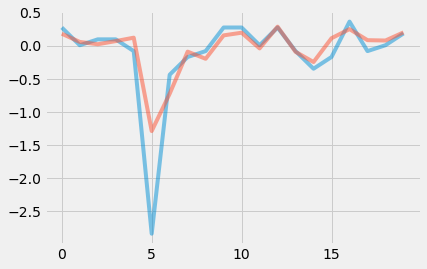

In [122]:
plt.plot(y_val[:, 0, 0].flatten()[175:195],alpha=0.5);
plt.plot(model5.predict(X_val)[:,0].flatten()[175:195], alpha=0.5);

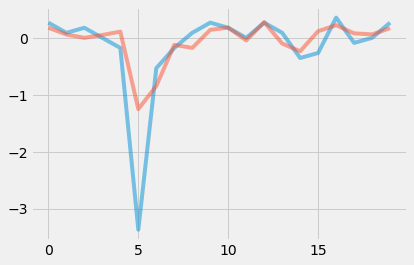

In [121]:
plt.plot(y_val[:, 1, 0].flatten()[175:195],alpha=0.5);
plt.plot(model5.predict(X_val)[:,1].flatten()[175:195], alpha=0.5);

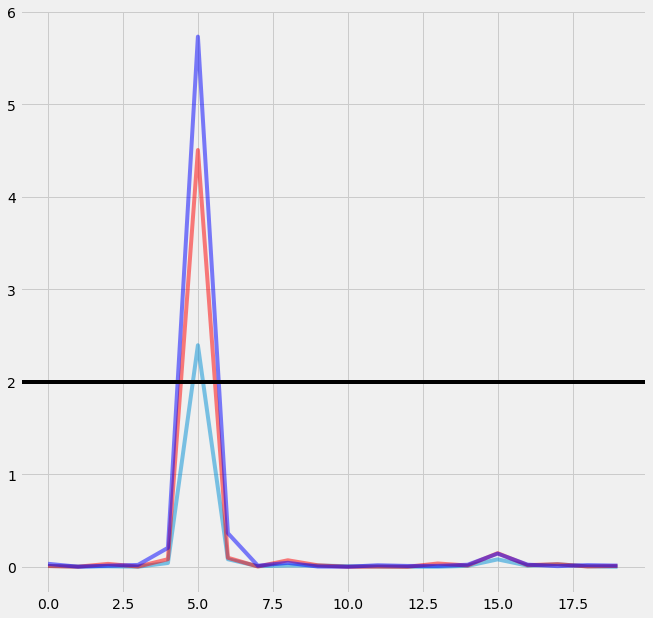

In [120]:
model = model5
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(range(20),((model.predict(X_val)[:,0].flatten()[175:195] - y_val[:, 0, 0].flatten()[175:195]) ** 2), alpha=0.5);#, color='yellow');
# axes[0].axhline(2, color='black')

ax.plot(range(20),((model.predict(X_val)[:,1].flatten()[175:195] - y_val[:, 1, 0].flatten()[175:195]) ** 2), alpha=0.5, color='red');
# axes[1].axhline(2, color='black')

ax.plot(range(20),((model.predict(X_val)[:,2].flatten()[175:195] - y_val[:, 2, 0].flatten()[175:195]) ** 2), alpha=0.5, color ='blue');
ax.axhline(2, color='black')

# axes[0].set_ylim(0,20)
# axes[1].set_ylim(0,20)
# axes[2].set_ylim(0,20)

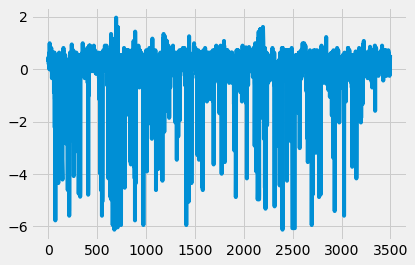

In [58]:
plt.plot(y_val[:, 0, 0].flatten())

In [25]:
X_val.mean()

-0.09374014733800225

In [26]:
X_val.std()

1.1893813834073865

In [ ]:
def sensor_etl(df, ID, filename, start_year = 2019, end_year = 2020):
    """
    
    
    """
    #file suffix
    if start_year == end_year:
        suffix = str(start_year)
    else:
        suffix = str(start_year) + '_' + str(end_year)
        
    #import libraries
    from IPython.display import clear_output

    # Group the time series into weekly buckets
    sens_weekly = sens_clean['SPEED'].resample('7D')

    # Take the mean of each group 
    sens_weekly_mean = sens_weekly.mean()
    
    #plot the generic trend and save the figure
    fig1, ax1 = plt.subplots(figsize=(16,8))
    sens_weekly_mean.plot(color='blue', ax=ax1);
    fig1.set_facecolor('white')
    fig1.suptitle('Weekly Traffic Speeds (' + filename + ')')
    ax1.grid(axis='y')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average Traffic Speed (MPH)')
    ax1.set_facecolor('white')
    for x in ['bottom', 'top', 'right', 'left']:
        ax1.spines[x].set_color('black')
    
    plt.savefig(filename + '_weekly_trend_' + suffix, bbox_inches='tight', facecolor='white')
    plt.close()

    #aggregate all of the data to each weekday and plot that data
    weekly_agg = day_of_week_agg(sens_clean)

    fig2, ax2 = plt.subplots(figsize=(16,8));
    for i in range(7):
        colors= ['blue', 'red', 'orange', 'green', 'gray', 'purple', 'darkblue']
        weekly_agg[i]['SPEED'].plot(ax=ax2, color=colors[i], alpha=0.75);
    color='black'   
    fig2.legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thurday', 'Friday', 'Saturday', 'Sunday']
               , edgecolor='black', framealpha=1, loc=(.85,.101), facecolor='white')
    fig2.set_facecolor('white')
    fig2.suptitle('Average Traffic Speeds Per Day (' + filename + ')', color=color)
    ax2.grid(axis='y')
    ax2.set_xticks([287, 251, 215, 179, 143, 107, 71, 35, 0])
    ax2.set_xticklabels(['12am', '9pm', '6pm', '3pm', '12pm', '9am', '6am', '3am', '12am'], color=color)
    ax2.set_xlabel('Time', color=color)
    ax2.set_ylabel('Average Traffic Speed (MPH)', color=color)
    ax2.set_facecolor('white')
    ax2.tick_params(axis='y', colors=color)
    for x in ['bottom', 'top', 'right', 'left']:
        ax2.spines[x].set_color('black')
    plt.savefig(filename + '_weekdays_' + suffix, bbox_inches='tight', facecolor='white')
    plt.close()

    #make the df stationary
    sens_clean = pd.DataFrame(sens_clean['SPEED'].copy().diff(2016))
    sens_clean.dropna(inplace = True)

    #number of steps to train on and predict on
    X_steps = 1440
    y_steps = 72

    #standardize data and split into train, val and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_dfs(dataframe = sens_clean, column = 'SPEED', X_steps = X_steps, y_steps = y_steps, standardize=True)

    #------MODELING------
    #Baseline
    y_pred = X_val[:, -y_steps:]

    baseline_loss = np.mean(mean_squared_error(y_val, y_pred))

#     #Vanilla Model
#     model1 = keras.models.Sequential([
#         keras.layers.Flatten(input_shape=[X_steps, 1]),
#         keras.layers.Dense(y_steps)
#     ])
#     model1.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 1/5')
#     history1 = model1.fit(X_train, y_train, epochs = 20)
#     train_loss1 = history1.history['loss'][-1]
#     val_loss1 = model1.evaluate(X_val, y_val)
#     clear_output(wait=True)
    
#     ## Deep RNN
#     model2 = keras.models.Sequential([
#         keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
#         keras.layers.SimpleRNN(10),
#         keras.layers.Dense(y_steps, activation='relu')
#     ])
#     model2.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 2/5')
#     history2 = model2.fit(X_train, y_train, epochs = 20)
#     train_loss2 = history2.history['loss'][-1]
#     val_loss2 = model2.evaluate(X_val, y_val)
#     clear_output(wait=True)

#     model3 = keras.models.Sequential([
#         keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 1]),
#         keras.layers.SimpleRNN(30),
#         keras.layers.Dense(y_steps, activation='relu')
#     ])
#     model3.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 3/5')
#     history3 = model3.fit(X_train, y_train, epochs = 20)
#     train_loss3 = history3.history['loss'][-1]
#     val_loss3 = model3.evaluate(X_val, y_val)
#     clear_output(wait=True)
    
    #fully connected neural nets
    model4 = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_steps, 1]),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dense(y_steps, activation='tanh')
    ])
    model4.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 4/5')
    history4 = model4.fit(X_train_std, y_train_std, epochs = 11, verbose=0)
    train_loss4 = history4.history['loss'][-1]
    val_loss4 = model4.evaluate(X_val_std, y_val_std, verbose=0)
    clear_output(wait=True)

    model5 = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_steps, 1]),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(500, activation='tanh'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(y_steps, activation='tanh')
    ])
    model5.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
#     print('Model 5/5')
    history5 = model5.fit(X_train_std, y_train_std, epochs = 11, verbose=0)
    train_loss5 = history5.history['loss'][-1]
    val_loss5 = model5.evaluate(X_val_std, y_val_std, verbose=0)
    clear_output(wait=True)
    
#     print(f'---Baseline---')
#     print(f'training loss: {baseline_loss:.3f} testing loss: {baseline_loss:.3f}')
#     print(f'---Vanilla---(Model 1)')
#     print(f'training loss: {train_loss1:.3f} testing loss: {val_loss1:.3f}')
#     print(f'---RNN (10 neurons)---(Model 2)')
#     print(f'training loss: {train_loss2:.3f} testing loss: {val_loss2:.3f}')
#     print(f'---RNN (30 neurons)---(Model 3)')
#     print(f'training loss: {train_loss3:.3f} testing loss: {val_loss3:.3f}')
#     print(f'---NN (1 dropout layer)---(Model 4)')
#     print(f'training loss: {train_loss4:.3f} testing loss: {val_loss4:.3f}')
#     print(f'---NN (3 dropout layers)---(Model 5)')
#     print(f'training loss: {train_loss5:.3f} testing loss: {val_loss5:.3f}')
    
    if val_loss5 < val_loss4:
        use_model = 5
    elif ((val_loss5 - train_loss5) < (val_loss4 - train_loss4)) & ((val_loss4 - train_loss4) - (val_loss5 - train_loss5) > (val_loss5 - val_loss4)):
        use_model = 5
    else:
        use_model = 4
    
    c.execute(f'''
                    INSERT INTO MODEL_PERFORMANCE_2015_2020 (sensor_id,
                                                   model4_train_loss,
                                                   model4_test_loss,
                                                   model5_train_loss,
                                                   model5_test_loss,
                                                   final_model)
                                VALUES ({ID},
                                        {train_loss4},
                                        {val_loss4},
                                        {train_loss5},
                                        {val_loss5},
                                        {use_model})

              ''')
    
    conn.commit()
    
    if use_model == 1:
        model1.save(filename + '_model_' + suffix)
    elif use_model == 2:
        model2.save(filename + '_model_' + suffix)
    elif use_model == 3:
        model3.save(filename + '_model_' + suffix)
    elif use_model == 4:
        model4.save(filename + '_model_' + suffix)
    else:
        model5.save(filename + '_model_' + suffix)
      
    clear_output(wait=True)

In [ ]:
df['ID'].unique()

In [ ]:
import tqdm
start_year = 2015
end_year = 2020
ids = list(df[(df['DATA_AS_OF'] > str(start_year)) & (df['DATA_AS_OF'] < str(end_year + 1))]['ID'].unique())
# index = ids.index(2)
# ids = ids[index+1:]
for x in tqdm.tqdm(ids):
    sensor_etl(df, x, 'Sensor' + str(x), start_year, end_year)

In [ ]:
ids[45]

In [ ]:
import sqlite3
import pandas as pd
from pandas import DataFrame

conn = sqlite3.connect('traffic_flow.db')
c = conn.cursor()

In [ ]:
# Create table - MODEL_PERFORMANCE
c.execute('''CREATE TABLE MODEL_PERFORMANCE_2015_2020
             ([sensor_id] INTEGER PRIMARY KEY,
             [model1_train_loss] float,
             [model1_test_loss] float,
             [model2_train_loss] float,
             [model2_test_loss] float,
             [model3_train_loss] float,
             [model3_test_loss] float,
             [model4_train_loss] float,
             [model4_test_loss] float,
             [model5_train_loss] float,
             [model5_test_loss] float,
             [final_model] integer)''')
          

In [ ]:
conn.commit()

In [ ]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

In [ ]:
c.execute("DELETE FROM MODEL_PERFORMANCE ")

In [ ]:
conn.commit()

In [ ]:
conn.close()

In [ ]:
train_loss4 = 1.6
val_loss4 = 2.3
train_loss5 = 2.2
val_loss5 = 2.6

if val_loss5 < val_loss4:
    use_model = 5
elif ((val_loss5 - train_loss5) < (val_loss4 - train_loss4)) & ((val_loss4 - train_loss4) - (val_loss5 - train_loss5) > (val_loss5 - val_loss4)):
    use_model = 5
else:
    use_model = 4
use_model

In [ ]:
df[(df['DATA_AS_OF'] > '2015') & (df['DATA_AS_OF'] < '2021')].shape

In [ ]:
stand = df
condition = [stand['SPEED'] == 0]
choices = [np.nan]
stand['SPEED'] = np.select(condition, choices, default=stand['SPEED'])
stand.fillna(method = 'ffill', inplace = True)

In [ ]:
stand['SPEED'].mean()

In [ ]:
stand['SPEED'].std() * 0.3

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('map.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
import os
import time
from selenium import webdriver

delay=5
fn='test.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Safari()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('map.png')
browser.quit()